**Objective:** To build and evaluate machine learning and deep learning models to predict whether the next day's closing price of AAPL stock will be higher than the current day's closing price.

---
---
# Import Libraries

In [8]:
!pip install yfinance
!pip install optuna

In [9]:
# --- Core Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Data Acquisition ---
import yfinance as yf
from datetime import datetime

# --- Preprocessing & Feature Engineering ---
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

# --- Modeling ---
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Evaluation ---
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# --- Hyperparameter Tuning ---
import optuna

# --- Configuration ---
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_theme()

---
# Data Acquisition & Initial Exploration

In [11]:
# --- Parameters ---
TICKER = 'AAPL'
START_DATE = '2010-01-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')

# --- Download Data from yfinance ---
print(f"Downloading data for {TICKER} from {START_DATE} to {END_DATE}...")
try:
    df_raw = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
    if df_raw.empty:
        raise ValueError("No data downloaded")
    # Flatten the MultiIndex columns
    df_raw.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_raw.columns.values]
    print("Data downloaded successfully.")
    print(f"Data shape: {df_raw.shape}")
    print("\nFirst 5 rows:")
    print(df_raw.head())
    print("\nData Info:")
    print(df_raw.info())
except Exception as e:
    print(f"Error downloading data: {e}")
    raise

Data downloaded successfully.
Data shape: (3914, 5)

First 5 rows:
            Close_AAPL  High_AAPL  Low_AAPL  Open_AAPL  Volume_AAPL
Date                                                               
2010-01-04    6.431895   6.446622  6.382907   6.414464    493729600
2010-01-05    6.443017   6.479382  6.409055   6.449629    601904800
2010-01-06    6.340531   6.468562  6.333919   6.443016    552160000
2010-01-07    6.328811   6.371488  6.282828   6.363974    477131200
2010-01-08    6.370886   6.371488  6.283129   6.320395    447610800

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3914 entries, 2010-01-04 to 2025-07-25
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close_AAPL   3914 non-null   float64
 1   High_AAPL    3914 non-null   float64
 2   Low_AAPL     3914 non-null   float64
 3   Open_AAPL    3914 non-null   float64
 4   Volume_AAPL  3914 non-null   int64  
dtypes: float64(4), int64(1

---
# Feature Engineering: Creating Predictors

In [12]:
# Create a copy to preserve the raw data
df = df_raw.copy()

# 1. Create the Target Variable
# Predict if the *next day's* price will go up (1) or not (0)
df['Target'] = (df['Close_AAPL'].shift(-1) > df['Close_AAPL']).astype(int)

# 2. Calculate Technical Indicators
print("\nCalculating technical indicators...")

# Moving Averages
df['SMA_10'] = df['Close_AAPL'].rolling(window=10).mean()
df['SMA_20'] = df['Close_AAPL'].rolling(window=20).mean()
df['EMA_10'] = df['Close_AAPL'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close_AAPL'].ewm(span=20, adjust=False).mean()

# Price ratios to moving averages
df['Price_to_SMA10'] = df['Close_AAPL'] / df['SMA_10']
df['Price_to_SMA20'] = df['Close_AAPL'] / df['SMA_20']

# Momentum Indicators
df['ROC_5'] = (df['Close_AAPL'] / df['Close_AAPL'].shift(5) - 1) * 100
df['ROC_10'] = (df['Close_AAPL'] / df['Close_AAPL'].shift(10) - 1) * 100

# RSI (Relative Strength Index)
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    # Handle division by zero for rs calculation
    rs = gain / loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

df['RSI_14'] = calculate_rsi(df['Close_AAPL'])

# Williams %R
def calculate_williams_r(high, low, close, window=14):
    highest_high = high.rolling(window=window).max()
    lowest_low = low.rolling(window=window).min()
    # Handle division by zero
    range_diff = highest_high - lowest_low
    return -100 * ((highest_high - close) / range_diff.replace(0, np.nan))

df['WNR_14'] = calculate_williams_r(df['High_AAPL'], df['Low_AAPL'], df['Close_AAPL'])

# Bollinger Bands
df['BB_Middle'] = df['Close_AAPL'].rolling(window=20).mean()
rolling_std = df['Close_AAPL'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + (rolling_std * 2)
df['BB_Lower'] = df['BB_Middle'] - (rolling_std * 2)
# Handle division by zero and ensure Series for calculation
bb_range = (df['BB_Upper'] - df['BB_Lower']).squeeze() # Use squeeze to ensure it's a Series
df['BB_Position'] = (df['Close_AAPL'] - df['BB_Lower']).squeeze() / bb_range.replace(0, np.nan)


# Volume indicators
df['Volume_SMA'] = df['Volume_AAPL'].rolling(window=10).mean()
# Handle division by zero and ensure Series for calculation
df['Volume_Ratio'] = df['Volume_AAPL'].squeeze() / df['Volume_SMA'].replace(0, np.nan).squeeze()

# 3. Create Lag Features
for lag in range(1, 6):
    df[f'Close_lag_{lag}'] = df['Close_AAPL'].shift(lag)
    df[f'Volume_lag_{lag}'] = df['Volume_AAPL'].shift(lag)
    df[f'Return_lag_{lag}'] = df['Close_AAPL'].pct_change(lag)

# 4. Clean up data
# Drop the last row as its target is NaN
df = df[:-1]
# Drop rows with NaN values
df.dropna(inplace=True)

print("Feature engineering complete.")
print(f"Final data shape: {df.shape}")
print(f"Target distribution:\n{df['Target'].value_counts()}")


Calculating technical indicators...
Feature engineering complete.
Final data shape: (3894, 37)
Target distribution:
Target
1    2069
0    1825
Name: count, dtype: int64


---
# Functions for Evaluation

In [13]:
def plot_feature_importance(model, feature_names, top_n=15):
    """Plots the feature importance for a tree-based model."""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        # Ensure feature_names and importances have the same length
        if len(feature_names) != len(importances):
             print(f"Warning: Feature names ({len(feature_names)}) and importances ({len(importances)}) length mismatch. Skipping feature importance plot.")
             return

        df_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
        df_importance = df_importance.sort_values('importance', ascending=False).head(top_n)

        plt.figure(figsize=(10, 8))
        plt.barh(range(len(df_importance)), df_importance['importance'])
        plt.yticks(range(len(df_importance)), df_importance['feature'])
        plt.xlabel('Importance Score')
        plt.title(f'Top {top_n} Feature Importances')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

def evaluate_model(model, X_test, y_test, feature_names=None, model_name="Model"):
    """Evaluates the model's performance and visualizes results."""
    print(f"--- {model_name} Performance Evaluation ---")

    # Handle different model types
    try:
        if hasattr(model, 'predict_proba'):  # For sklearn models
            y_pred_prob = model.predict_proba(X_test)[:, 1]
        else:  # For Keras/TF models
            y_pred_prob = model.predict(X_test, verbose=0).ravel()

        y_pred = (y_pred_prob > 0.5).astype(int)
    except Exception as e:
        print(f"Error making predictions: {e}")
        return

    # Calculate metrics
    try:
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_pred_prob)

        print(f"Accuracy:  {accuracy:.2%}")
        print(f"Precision: {precision:.2%}")
        print(f"Recall:    {recall:.2%}")
        print(f"F1-Score:  {f1:.2%}")
        print(f"ROC-AUC:   {roc_auc:.4f}")

        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.colorbar()

        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.xticks([0, 1], ['Down/Stay', 'Up'])
        plt.yticks([0, 1], ['Down/Stay', 'Up'])
        plt.tight_layout()
        plt.show()

        # Plot Feature Importance if available and shapes match
        if feature_names is not None:
             plot_feature_importance(model, feature_names)


        return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc}

    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return None

---
# Data Preprocessing & Splitting

In [14]:
# Define Features (X) and Target (y)
# Exclude original OHLCV columns and target to prevent data leakage
exclude_cols = ['Open_AAPL', 'High_AAPL', 'Low_AAPL', 'Close_AAPL', 'Adj Close_AAPL', 'Volume_AAPL', 'Target']
features = [col for col in df.columns if col not in exclude_cols]
X = df[features]
y = df['Target']

print(f"Selected features: {len(features)}")
print(f"Features: {features}")

# Time-based Train-Test Split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Feature Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check for any remaining NaN or infinite values
print(f"NaN values in training set: {np.isnan(X_train_scaled).sum()}")
print(f"Infinite values in training set: {np.isinf(X_train_scaled).sum()}")

Selected features: 31
Features: ['SMA_10', 'SMA_20', 'EMA_10', 'EMA_20', 'Price_to_SMA10', 'Price_to_SMA20', 'ROC_5', 'ROC_10', 'RSI_14', 'WNR_14', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Position', 'Volume_SMA', 'Volume_Ratio', 'Close_lag_1', 'Volume_lag_1', 'Return_lag_1', 'Close_lag_2', 'Volume_lag_2', 'Return_lag_2', 'Close_lag_3', 'Volume_lag_3', 'Return_lag_3', 'Close_lag_4', 'Volume_lag_4', 'Return_lag_4', 'Close_lag_5', 'Volume_lag_5', 'Return_lag_5']
Training set shape: (3115, 31)
Testing set shape: (779, 31)
NaN values in training set: 0
Infinite values in training set: 0


---
# Model 1: XGBoost with Hyperparameter Tuning

In [15]:
def objective(trial):
    """Objective function for Optuna optimization."""
    try:
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
            'random_state': 42
        }

        model = xgb.XGBClassifier(**params)
        model.fit(X_train_scaled, y_train,
                 eval_set=[(X_test_scaled, y_test)],
                 verbose=False)

        preds_proba = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, preds_proba)
        return auc
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.5  # Return baseline score for failed trials

[I 2025-07-27 16:27:45,576] A new study created in memory with name: no-name-ade10357-7bad-400b-ae5c-76b4675a2e2d



Starting Hyperparameter Tuning with Optuna...


[I 2025-07-27 16:27:48,523] Trial 0 finished with value: 0.49251890171110224 and parameters: {'n_estimators': 169, 'learning_rate': 0.26332330979553786, 'max_depth': 6, 'subsample': 0.7504179593576396, 'colsample_bytree': 0.8561589549692854, 'reg_alpha': 0.8015599154052184, 'reg_lambda': 0.03681644820651664}. Best is trial 0 with value: 0.49251890171110224.
[I 2025-07-27 16:27:50,864] Trial 1 finished with value: 0.4880355484812309 and parameters: {'n_estimators': 243, 'learning_rate': 0.016616159567107304, 'max_depth': 3, 'subsample': 0.9254606622663636, 'colsample_bytree': 0.6020587777368769, 'reg_alpha': 0.42079552860596625, 'reg_lambda': 0.87937691415317}. Best is trial 0 with value: 0.49251890171110224.
[I 2025-07-27 16:27:54,294] Trial 2 finished with value: 0.4706658708051466 and parameters: {'n_estimators': 121, 'learning_rate': 0.11583803776804685, 'max_depth': 6, 'subsample': 0.7190830153379435, 'colsample_bytree': 0.865904102288658, 'reg_alpha': 0.26902578726987536, 'reg_lam

Best parameters: {'n_estimators': 111, 'learning_rate': 0.15260031859627765, 'max_depth': 8, 'subsample': 0.6074322297573372, 'colsample_bytree': 0.9465851805843751, 'reg_alpha': 0.6976257860149216, 'reg_lambda': 0.18755560930085258}
Best AUC score: 0.5312

Training final XGBoost model with best parameters...
--- Tuned XGBoost Performance Evaluation ---
Accuracy:  51.86%
Precision: 55.13%
Recall:    57.62%
F1-Score:  56.34%
ROC-AUC:   0.5312


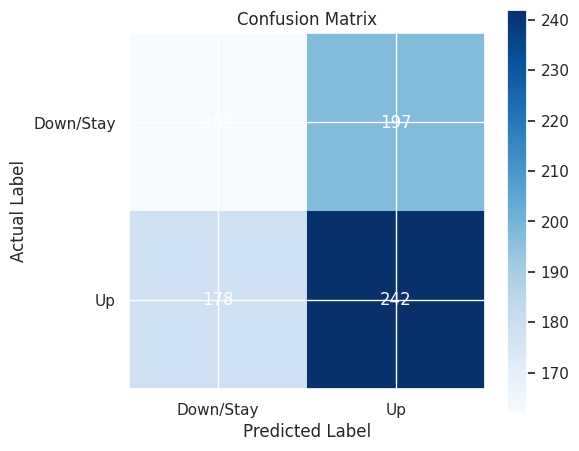

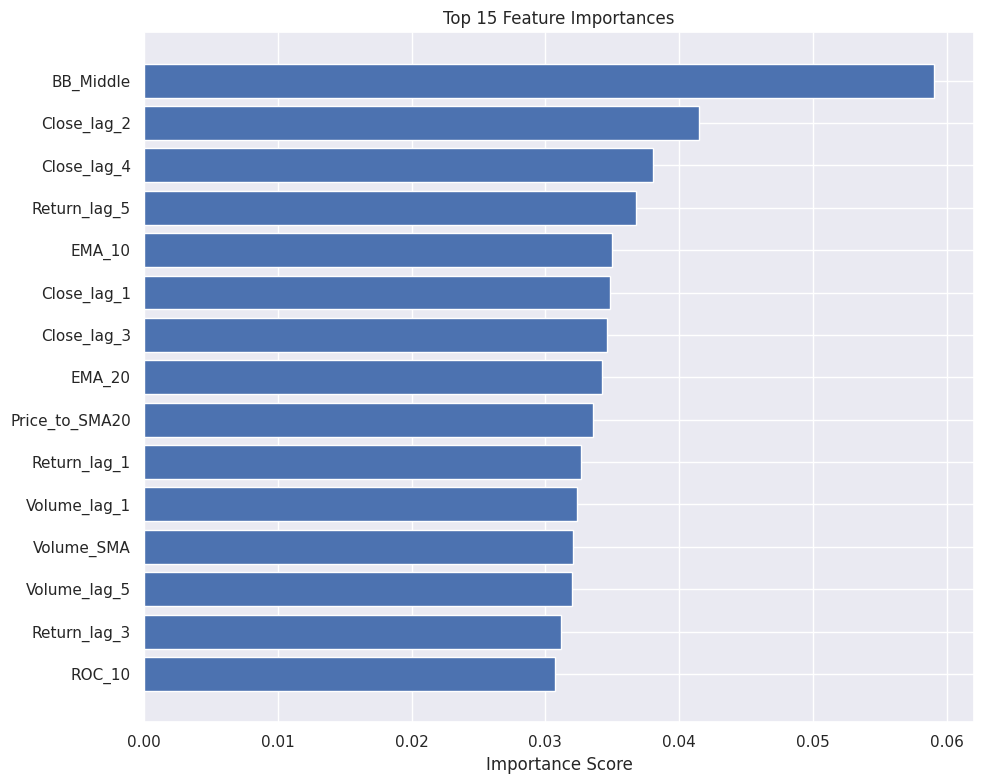

In [16]:
# Run Optuna Study
print("\nStarting Hyperparameter Tuning with Optuna...")
try:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20, timeout=600)  # 20 trials or 10 minutes

    print(f"Best parameters: {study.best_params}")
    print(f"Best AUC score: {study.best_value:.4f}")

    # Train Final Model with Best Parameters
    print("\nTraining final XGBoost model with best parameters...")
    best_params = study.best_params
    tuned_xgb_model = xgb.XGBClassifier(**best_params, random_state=42)
    tuned_xgb_model.fit(X_train_scaled, y_train)

    # Evaluate the Model
    xgb_results = evaluate_model(tuned_xgb_model, X_test_scaled, y_test,
                                feature_names=features, model_name="Tuned XGBoost")

except Exception as e:
    print(f"Error in XGBoost training: {e}")
    # Fallback to default parameters
    print("Using default XGBoost parameters...")
    tuned_xgb_model = xgb.XGBClassifier(random_state=42)
    tuned_xgb_model.fit(X_train_scaled, y_train)
    xgb_results = evaluate_model(tuned_xgb_model, X_test_scaled, y_test,
                                feature_names=features, model_name="Default XGBoost")

---
# Model 2: LSTM (Deep Learning)

Using 30 time steps for LSTM
LSTM Training shape: (3085, 30, 31)
LSTM Testing shape: (749, 30, 31)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,901 (148.05 KB)

 Trainable params: 37,901 (148.05 KB)

 Non-trainable params: 0 (0.00 B)

None

Training LSTM model...
Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5010 - loss: 0.6979 - val_accuracy: 0.5235 - val_loss: 0.6985 - learning_rate: 0.0010
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5219 - loss: 0.6953 - val_accuracy: 0.5235 - val_loss: 0.6916 - learning_rate: 0.0010
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5150 - loss: 0.6923 - val_accuracy: 0.5235 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5427 - loss: 0.6923 - val_accuracy: 0.5235 - val_loss: 0.6918 - learning_rate: 0.0010
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5359 - loss: 0.6917 - val_accuracy: 0.5235 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.5250 - loss: 0.6918 - val_accuracy: 0.5235 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0

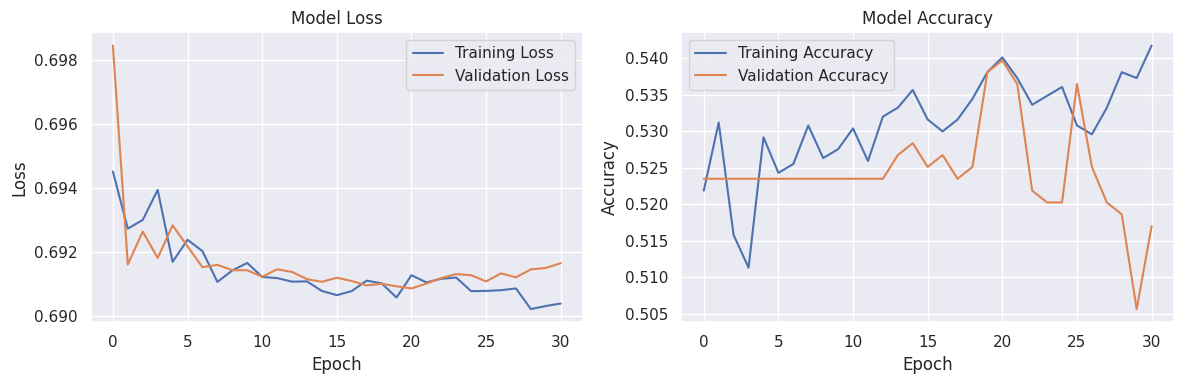

--- LSTM Performance Evaluation ---
Accuracy:  52.87%
Precision: 53.50%
Recall:    91.52%
F1-Score:  67.53%
ROC-AUC:   0.4872


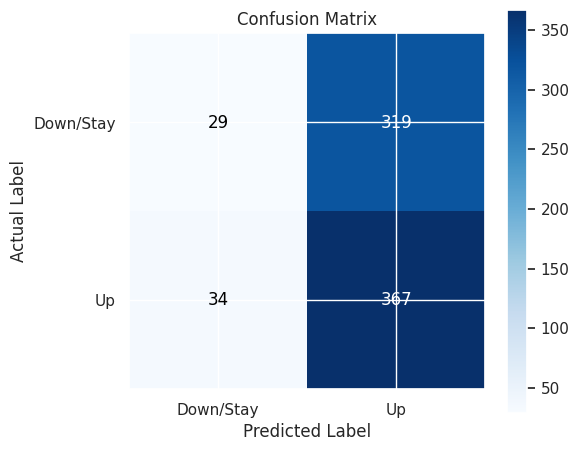

In [17]:
def create_lstm_sequences(X, y, time_steps=30):
    """Creates sequences for LSTM model training."""
    if len(X) <= time_steps:
        raise ValueError(f"Not enough data points. Need at least {time_steps + 1}, got {len(X)}")

    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Use shorter time steps to ensure we have enough data
TIME_STEPS = min(30, len(X_train_scaled) // 4)
print(f"Using {TIME_STEPS} time steps for LSTM")

try:
    X_train_lstm, y_train_lstm = create_lstm_sequences(X_train_scaled, y_train.values, TIME_STEPS)
    X_test_lstm, y_test_lstm = create_lstm_sequences(X_test_scaled, y_test.values, TIME_STEPS)

    print(f"LSTM Training shape: {X_train_lstm.shape}")
    print(f"LSTM Testing shape: {X_test_lstm.shape}")

    # Build the LSTM Model
    lstm_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(TIME_STEPS, X_train_lstm.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(lstm_model.summary())

    # Train the LSTM Model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    print("\nTraining LSTM model...")
    history = lstm_model.fit(
        X_train_lstm, y_train_lstm,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Plot Training History
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate LSTM
    lstm_results = evaluate_model(lstm_model, X_test_lstm, y_test_lstm, model_name="LSTM")

except Exception as e:
    print(f"Error in LSTM training: {e}")
    lstm_model = None
    lstm_results = None

---
# Final Prediction for Next Trading Day

In [18]:
print("\n--- Final Prediction for Next Trading Day ---")

try:
    # Use the most recent data point for prediction
    last_features_scaled = X_test_scaled[-1].reshape(1, -1)

    # XGBoost Prediction
    xgb_prob = tuned_xgb_model.predict_proba(last_features_scaled)[0, 1]
    xgb_pred = 1 if xgb_prob > 0.5 else 0

    print(f"XGBoost Model:")
    print(f"  - Probability of price INCREASE: {xgb_prob:.2%}")
    print(f"  - Prediction: {'INCREASE' if xgb_pred == 1 else 'DECREASE/STAY'}")

    # LSTM Prediction (if model was trained successfully)
    if lstm_model is not None and X_test_lstm.shape[0] > 0:
        last_sequence_lstm = X_test_lstm[-1].reshape(1, TIME_STEPS, -1)
        lstm_prob = lstm_model.predict(last_sequence_lstm, verbose=0)[0, 0]
        lstm_pred = 1 if lstm_prob > 0.5 else 0

        print(f"\nLSTM Model:")
        print(f"  - Probability of price INCREASE: {lstm_prob:.2%}")
        print(f"  - Prediction: {'INCREASE' if lstm_pred == 1 else 'DECREASE/STAY'}")

        # Ensemble prediction (average of both models)
        ensemble_prob = (xgb_prob + lstm_prob) / 2
        ensemble_pred = 1 if ensemble_prob > 0.5 else 0

        print(f"\nEnsemble Prediction (Average):")
        print(f"  - Probability of price INCREASE: {ensemble_prob:.2%}")
        print(f"  - Final Decision: {'INCREASE' if ensemble_pred == 1 else 'DECREASE/STAY'}")

    print(f"\nPrediction based on data up to: {X.index[-1].strftime('%Y-%m-%d')}")

except Exception as e:
    print(f"Error making final prediction: {e}")


--- Final Prediction for Next Trading Day ---
XGBoost Model:
  - Probability of price INCREASE: 75.51%
  - Prediction: INCREASE

LSTM Model:
  - Probability of price INCREASE: 52.12%
  - Prediction: INCREASE

Ensemble Prediction (Average):
  - Probability of price INCREASE: 63.81%
  - Final Decision: INCREASE

Prediction based on data up to: 2025-07-24
